Best threshold (F1): 0.472  →  F1: 0.863


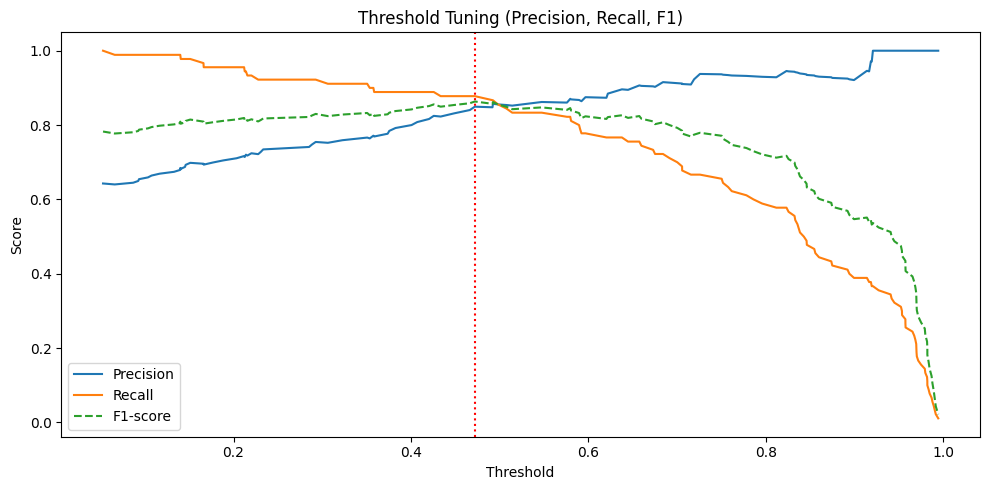

In [2]:
# notebooks/modeling/06_model_tuning.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score

# 1. Load data
df = pd.read_parquet("../../data/processed/model_ready.parquet")
target = "incident_occurred"

# Add age group as feature
def age_group(age):
    if age < 10: return "<10"
    elif age < 20: return "10–19"
    elif age < 30: return "20–29"
    elif age < 40: return "30–39"
    elif age < 50: return "40–49"
    elif age < 60: return "50–59"
    elif age < 70: return "60–69"
    else: return "70+"

df["age_group"] = df["age"].apply(age_group)

features = [
    "ride_type_simplified", "ride_incident_count", "duration_min",
    "age", "age_group", "gender", "simulated_medical_condition", "first_time_visitor",
    "season", "is_weekend", "temperature_max", "precipitation_sum"
]

df_model = pd.get_dummies(df[features + [target]], drop_first=True).dropna()

# 2. Split
df_model = df_model.sample(frac=1, random_state=42)
X = df_model.drop(columns=target)
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# 3. Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_probs = model.predict_proba(X_test)[:, 1]

# 4. Threshold tuning
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)

best_idx = np.argmax(f1s)
best_thresh = thresholds[best_idx]
print(f"Best threshold (F1): {best_thresh:.3f}  →  F1: {f1s[best_idx]:.3f}")

# 5. Plot
plt.figure(figsize=(10,5))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, f1s[:-1], label="F1-score", linestyle="--")
plt.axvline(best_thresh, color="r", linestyle=":")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning (Precision, Recall, F1)")
plt.legend()
plt.tight_layout()
plt.show()
